# Date Converter

We will be translating from one date format to another. In order to do this we need to connect two set of LSTMs (RNNs). The diagram looks as follows: Each set respectively sharing weights (i.e. each of the 4 green cells have the same weights and similarly with the blue cells). The first is a many to one LSTM, which summarises the question at the last hidden layer (and cell memory).

The second set (blue) is a Many to Many LSTM which has different weights to the first set of LSTMs. The input is simply the answer sentence while the output is the same sentence shifted by one. Ofcourse during testing time there are no inputs for the `answer` and is only used during training.
![seq2seq_diagram](https://i.stack.imgur.com/YjlBt.png) 

**20th January 2017 => 20th January 2009**
![troll](../images/troll_face.png)

## References:
1. Plotting Tensorflow graph: https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/38192374#38192374
2. The generation process was taken from: https://github.com/datalogue/keras-attention/blob/master/data/generate.py
3. 2014 paper with 2000+ citations: https://arxiv.org/pdf/1409.3215.pdf

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/_Sm0q_FckM8?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

In [2]:
!pip install faker babel

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


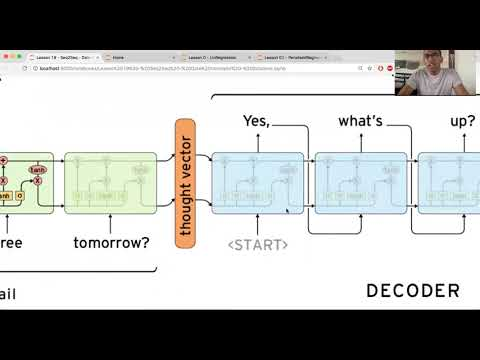

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("_Sm0q_FckM8")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
import json
import os
import time

from faker import Faker
import babel
from babel.dates import format_date

import tensorflow as tf

import tensorflow.contrib.legacy_seq2seq as seq2seq
from utilities import show_graph

from sklearn.model_selection import train_test_split

In [5]:
fake = Faker()
fake.seed(42)
random.seed(42)

FORMATS = ['short',
           'medium',
           'long',
           'full',
           'd MMM YYY',
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY',
           ]

# change this if you want it to work with only a single language
LOCALES = babel.localedata.locale_identifiers()
LOCALES = [lang for lang in LOCALES if 'en' in str(lang)]

In [6]:
def create_date():
    """
        Creates some fake dates 
        :returns: tuple containing 
                  1. human formatted string
                  2. machine formatted string
                  3. date object.
    """
    dt = fake.date_object()

    # wrapping this in a try catch because
    # the locale 'vo' and format 'full' will fail
    try:
        human = format_date(dt,
                            format=random.choice(FORMATS),
                            locale=random.choice(LOCALES))

        case_change = random.randint(0,3) # 1/2 chance of case change
        if case_change == 1:
            human = human.upper()
        elif case_change == 2:
            human = human.lower()

        machine = dt.isoformat()
    except AttributeError as e:
        return None, None, None

    return human, machine #, dt

data = [create_date() for _ in range(50000)]

See below what we are trying to do in this lesson. We are taking dates of various formats and converting them into a standard date format:

In [7]:
data[:5]

[(u'04, DEC 2000', '2000-12-04'),
 (u'thursday, 18 march 1971', '1971-03-18'),
 (u'APRIL 21, 1983', '1983-04-21'),
 (u'17/10/1980', '1980-10-17'),
 (u'14/08/05', '2005-08-14')]

In [8]:
x = [x for x, y in data]
y = [y for x, y in data]

u_characters = set(' '.join(x))
char2numX = dict(zip(u_characters, range(len(u_characters))))

u_characters = set(' '.join(y))
char2numY = dict(zip(u_characters, range(len(u_characters))))

Pad all sequences that are shorter than the max length of the sequence

In [9]:
char2numX['<PAD>'] = len(char2numX)
num2charX = dict(zip(char2numX.values(), char2numX.keys()))
max_len = max([len(date) for date in x])

x = [[char2numX['<PAD>']]*(max_len - len(date)) +[char2numX[x_] for x_ in date] for date in x]
print(''.join([num2charX[x_] for x_ in x[4]]))
x = np.array(x)

1


In [10]:
char2numY['<GO>'] = len(char2numY)
num2charY = dict(zip(char2numY.values(), char2numY.keys()))

y = [[char2numY['<GO>']] + [char2numY[y_] for y_ in date] for date in y]
print(''.join([num2charY[y_] for y_ in y[4]]))
y = np.array(y)

<GO>2005-08-14


In [11]:
x_seq_length = len(x[0])
y_seq_length = len(y[0])- 1

In [12]:
def batch_data(x, y, batch_size):
    shuffle = np.random.permutation(len(x))
    start = 0
#     from IPython.core.debugger import Tracer; Tracer()()
    x = x[shuffle]
    y = y[shuffle]
    while start + batch_size <= len(x):
        yield x[start:start+batch_size], y[start:start+batch_size]
        start += batch_size

In [13]:
epochs = 2
batch_size = 128
nodes = 32
embed_size = 10
bidirectional = True

tf.reset_default_graph()
sess = tf.InteractiveSession()

# Tensor where we will feed the data into graph
inputs = tf.placeholder(tf.int32, (None, x_seq_length), 'inputs')
outputs = tf.placeholder(tf.int32, (None, None), 'output')
targets = tf.placeholder(tf.int32, (None, None), 'targets')

# Embedding layers
input_embedding = tf.Variable(tf.random_uniform((len(char2numX), embed_size), -1.0, 1.0), name='enc_embedding')
output_embedding = tf.Variable(tf.random_uniform((len(char2numY), embed_size), -1.0, 1.0), name='dec_embedding')
date_input_embed = tf.nn.embedding_lookup(input_embedding, inputs)
date_output_embed = tf.nn.embedding_lookup(output_embedding, outputs)

with tf.variable_scope("encoding") as encoding_scope:

    if not bidirectional:
        
        # Regular approach with LSTM units
        lstm_enc = tf.contrib.rnn.LSTMCell(nodes)
        _, last_state = tf.nn.dynamic_rnn(lstm_enc, inputs=date_input_embed, dtype=tf.float32)

    else:
        
        # Using a bidirectional LSTM architecture instead
        enc_fw_cell = tf.contrib.rnn.LSTMCell(nodes)
        enc_bw_cell = tf.contrib.rnn.LSTMCell(nodes)

        ((enc_fw_out, enc_bw_out) , (enc_fw_final, enc_bw_final)) = tf.nn.bidirectional_dynamic_rnn(cell_fw=enc_fw_cell,
                                                        cell_bw=enc_bw_cell, inputs=date_input_embed, dtype=tf.float32)
        enc_fin_c = tf.concat((enc_fw_final.c , enc_bw_final.c),1)
        enc_fin_h = tf.concat((enc_fw_final.h , enc_bw_final.h),1)
        last_state = tf.contrib.rnn.LSTMStateTuple(c=enc_fin_c , h=enc_fin_h)
    
    
with tf.variable_scope("decoding") as decoding_scope:
    
    if not bidirectional:      
        lstm_dec = tf.contrib.rnn.LSTMCell(nodes)    
    else:
        lstm_dec = tf.contrib.rnn.LSTMCell(2*nodes)
    
    dec_outputs, _ = tf.nn.dynamic_rnn(lstm_dec, inputs=date_output_embed, initial_state=last_state)

        

logits = tf.layers.dense(dec_outputs, units=len(char2numY), use_bias=True) 
    
    
#connect outputs to 
with tf.name_scope("optimization"):
    # Loss function
    loss = tf.contrib.seq2seq.sequence_loss(logits, targets, tf.ones([batch_size, y_seq_length]))
    # Optimizer
    optimizer = tf.train.RMSPropOptimizer(1e-3).minimize(loss)

In [14]:
dec_outputs.get_shape().as_list()

[None, None, 64]

In [15]:
last_state[0].get_shape().as_list()

[None, 64]

In [16]:
inputs.get_shape().as_list()

[None, 1]

In [17]:
date_input_embed.get_shape().as_list()

[None, 1, 10]

Train the graph above:

In [18]:
show_graph(tf.get_default_graph().as_graph_def())

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [8, 50000]

In [17]:
sess.run(tf.global_variables_initializer())
epochs = 10
for epoch_i in range(epochs):
    start_time = time.time()
    for batch_i, (source_batch, target_batch) in enumerate(batch_data(X_train, y_train, batch_size)):
        _, batch_loss, batch_logits = sess.run([optimizer, loss, logits],
            feed_dict = {inputs: source_batch,
             outputs: target_batch[:, :-1],
             targets: target_batch[:, 1:]})
    accuracy = np.mean(batch_logits.argmax(axis=-1) == target_batch[:,1:])
    print('Epoch {:3} Loss: {:>6.3f} Accuracy: {:>6.4f} Epoch duration: {:>6.3f}s'.format(epoch_i, batch_loss, 
                                                                      accuracy, time.time() - start_time))

Epoch   0 Loss:  1.039 Accuracy: 0.6031 Epoch duration:  5.724s
Epoch   1 Loss:  0.701 Accuracy: 0.7328 Epoch duration:  5.365s
Epoch   2 Loss:  0.580 Accuracy: 0.7844 Epoch duration:  5.459s
Epoch   3 Loss:  0.439 Accuracy: 0.8422 Epoch duration:  5.431s
Epoch   4 Loss:  0.344 Accuracy: 0.8766 Epoch duration:  5.362s
Epoch   5 Loss:  0.346 Accuracy: 0.8750 Epoch duration:  5.380s
Epoch   6 Loss:  0.262 Accuracy: 0.9008 Epoch duration:  5.407s
Epoch   7 Loss:  0.232 Accuracy: 0.9047 Epoch duration:  5.367s
Epoch   8 Loss:  0.145 Accuracy: 0.9563 Epoch duration:  5.410s
Epoch   9 Loss:  0.089 Accuracy: 0.9789 Epoch duration:  5.364s


Translate on test set

In [18]:
source_batch, target_batch = next(batch_data(X_test, y_test, batch_size))

dec_input = np.zeros((len(source_batch), 1)) + char2numY['<GO>']
for i in range(y_seq_length):
    batch_logits = sess.run(logits,
                feed_dict = {inputs: source_batch,
                 outputs: dec_input})
    prediction = batch_logits[:,-1].argmax(axis=-1)
    dec_input = np.hstack([dec_input, prediction[:,None]])
    
print('Accuracy on test set is: {:>6.3f}'.format(np.mean(dec_input == target_batch)))

Accuracy on test set is:  0.923


Let's randomly take two from this test set and see what it spits out:

In [ ]:
num_preds = 2
source_chars = [[num2charX[l] for l in sent if num2charX[l]!="<PAD>"] for sent in source_batch[:num_preds]]
dest_chars = [[num2charY[l] for l in sent] for sent in dec_input[:num_preds, 1:]]

for date_in, date_out in zip(source_chars, dest_chars):
    print(''.join(date_in)+' => '+''.join(date_out))

In [ ]:
source_batch[0]